In [259]:
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import functools
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

COMPLEMENT = {"A": "T", "C": "G", "G": "C", "T": "A"}


def revcomp(seq):
    return "".join(COMPLEMENT[base] for base in reversed(seq))


def rle(inarray):
    """run length encoding. Partial credit to R rle function.
    Multi datatype arrays catered for including non Numpy
    returns: tuple (runlengths, startpositions, values)
    input: array
    output: tuple of (run_lengths, start_positions, values)"""
    ia = np.asarray(inarray)  # force numpy
    n = len(ia)
    if n == 0:
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]  # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)  # must include last element position
        z = np.diff(np.append(-1, i))  # run lengths
        p = np.cumsum(np.append(0, z))[:-1]  # positions
        return (z, p, ia[i])


# make all possible 3-mers
# @functools.cache
def make_kmer_dict(kmer_size, use_canonical=False):
    kmer_dict = {}
    for kmer_list in itertools.product(["A", "C", "G", "T"], repeat=kmer_size):
        kmer = "".join(kmer_list)
        rc_kmer = revcomp(kmer)
        if rc_kmer < kmer and use_canonical:
            kmer = rc_kmer
        # skip no m6a possible kmers
        if kmer.count("A") + kmer.count("T") == 0:
            continue
        kmer_dict[f"{kmer}_count"] = 0
        kmer_dict[f"{kmer}_m6a_count"] = 0
    return kmer_dict


def kmer_features(seq, m6a_bool, kmer_size=3, use_canonical=False):
    stop_index = len(seq) - kmer_size + 1
    kmer_counts = make_kmer_dict(kmer_size, use_canonical=use_canonical)
    for i in range(stop_index):
        # get current index
        kmer = seq[i : i + kmer_size]
        m6a_count = m6a_bool[i : i + kmer_size].sum()
        # skip no m6a possible kmers
        if kmer.count("A") + kmer.count("T") == 0:
            continue
        # get canonical kmer
        rc_kmer = revcomp(kmer)
        if rc_kmer < kmer and use_canonical:
            kmer = rc_kmer
        # counts
        kmer_counts[f"{kmer}_count"] += 1
        kmer_counts[f"{kmer}_m6a_count"] += m6a_count
    return kmer_counts

In [347]:
nrows=500_000
neg = pd.read_csv("../../ctcf-footprinting/mrv_misc/mrv_neg.tbl.gz", sep="\t", nrows=nrows)

In [348]:
pos = pd.read_csv("../../ctcf-footprinting/mrv_misc/mrv_pos.tbl.gz", sep="\t", nrows=nrows)

In [349]:
pos["Label"] = 1
neg["Label"] = -1
n=500_000
data = pd.concat([pos.head(n), neg.head(n)])

In [400]:
def features(g, motif_length=35, dist=100, flank_size=40):
    if g.shape[0] == 0:
        return {}
    
    motif_start = dist
    motif_end = dist + motif_length

    # skip if we are not in an msp region
    msp_starts = g[g.centered_position_type == "msp"].centered_start + dist
    msp_ends = g[g.centered_position_type == "msp"].centered_end + dist
    spanning_msp = (
        (msp_starts <= motif_start)
        & (msp_ends >= motif_end)
        # & (msp_ends - msp_starts > 85)
        # & (msp_ends - msp_starts < 1000)
    )
    if not spanning_msp.any():
        return {}
    # print(g[g.centered_position_type == "msp"])

    # get sequence and sequence features
    seq = g.subset_sequence.unique()[0]
    np_seq = np.frombuffer(bytes(seq, "utf-8"), dtype="S1")
    AT_bases = (np_seq == b"A") | (np_seq == b"T")
    motif = seq[motif_start:motif_end]
    AT_motif_bases = AT_bases[motif_start:motif_end]

    # skip if has N, shouldn't happen often after msp filter
    if "N" in seq:
        return {}

    # make m6a boolean
    m6a_positions = np.array(g[g.centered_position_type == "m6a"].centered_start) + dist
    m6a_bool = np.zeros(2 * dist + 1)
    m6a_bool[m6a_positions] = 1
    m6a_motif_bool = m6a_bool[motif_start:motif_end]

    # k-mer features
    feats = kmer_features(motif, m6a_motif_bool, kmer_size=3, use_canonical=False)

    # RLE
    # get run lengths using the AT base space
    run_lengths, _run_starts, run_values = rle(m6a_motif_bool[AT_motif_bases])
    if run_lengths is None or run_values is None:
        feats["rle_max"] = 0
    else:
        # need to subset to the run lengths that encode zeros (non-m6a):
        non_m6a_run_lengths = run_lengths[run_values == 0]
        if non_m6a_run_lengths.shape[0] == 0:
            feats["rle_max"] = 0
        else:
            feats["rle_max"] = max(non_m6a_run_lengths)

    # other motif wide features
    feats["left_m6a"] = m6a_bool[(motif_start - flank_size) : motif_start].sum()
    feats["right_m6a"] = m6a_bool[motif_end : (motif_end + flank_size)].sum()
    feats["motif_m6a"] = m6a_bool[motif_start:motif_end].sum()
    feats["motif_frac_m6a"] = feats["motif_m6a"] / AT_motif_bases.sum()
    feats["motif_AT_bp"] = AT_motif_bases.sum()

    # need label from beginning from mokapot
    feats["Label"] = g.Label.unique()[0]
    feats["msp_start"] = max(msp_starts[spanning_msp].values[0], -200)
    feats["msp_end"] = min(msp_ends[spanning_msp].values[0], 300)
    return feats

print(data.shape)
rtn_list = (
    data.groupby(
        [
            "chrom",
            "centering_position",
            "strand",
            #"subset_sequence",
            "query_name",
            "centered_query_start",
            "centered_query_end",
        ]
    )
    .apply(features)
    .tolist()
)
dirty_pin = pd.DataFrame(rtn_list)

(1000000, 14)


In [406]:
pin = dirty_pin.dropna().copy()
pin.insert(0, "SpecId", pin.index)
pin["Peptide"] = pin.SpecId
pin["Proteins"] = pin.SpecId
pin["scannr"] = pin.SpecId

In [445]:
import mokapot
import logging

logging.basicConfig(
        level=logging.INFO,
        format="%(levelname)s: %(message)s",
)
 
psms = mokapot.read_pin(pin)
model = mokapot.PercolatorModel(train_fdr=0.1, direction="rle_max")
mokapot_conf, models = mokapot.brew(psms, model, test_fdr=0.05)


/mmfs1/gscratch/stergachislab/mvollger/miniconda3/envs/fiberseq-smk/lib/python3.9/site-packages/triqler/qvality.py:234: RuntimeWarning: invalid value encountered in log
  gnew = np.log(p / (1-p))


/mmfs1/gscratch/stergachislab/mvollger/miniconda3/envs/fiberseq-smk/lib/python3.9/site-packages/triqler/qvality.py:234: RuntimeWarning: invalid value encountered in log
  gnew = np.log(p / (1-p))


 1.0    9323
-1.0    4282
Name: Label, dtype: int64

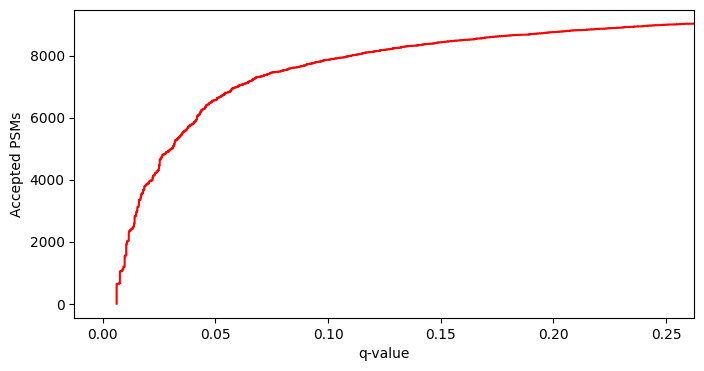

In [447]:
import matplotlib.pyplot as plt

tide_conf = psms.assign_confidence(pin.rle_max, eval_fdr=0.2)
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
mokapot_conf.plot_qvalues(label="mokapot", color="red", ax=axs, threshold=.25)
tide_conf.plot_qvalues(label="naive", color="blue", ax=axs, threshold=.25)
pin.Label.value_counts()

In [444]:
psms

A mokapot.dataset.LinearPsmDataset with 13605 PSMs:
	- Protein confidence estimates enabled: False
	- Target PSMs: 9323
	- Decoy PSMs: 4282
	- Unique spectra: 13605
	- Unique peptides: 13605
	- Features: ('AAA_count', 'AAA_m6a_count', 'AAC_count', 'AAC_m6a_count', 'AAG_count', 'AAG_m6a_count', 'AAT_count', 'AAT_m6a_count', 'ACA_count', 'ACA_m6a_count', 'ACC_count', 'ACC_m6a_count', 'ACG_count', 'ACG_m6a_count', 'ACT_count', 'ACT_m6a_count', 'AGA_count', 'AGA_m6a_count', 'AGC_count', 'AGC_m6a_count', 'AGG_count', 'AGG_m6a_count', 'AGT_count', 'AGT_m6a_count', 'ATA_count', 'ATA_m6a_count', 'ATC_count', 'ATC_m6a_count', 'ATG_count', 'ATG_m6a_count', 'ATT_count', 'ATT_m6a_count', 'CAA_count', 'CAA_m6a_count', 'CAC_count', 'CAC_m6a_count', 'CAG_count', 'CAG_m6a_count', 'CAT_count', 'CAT_m6a_count', 'CCA_count', 'CCA_m6a_count', 'CCT_count', 'CCT_m6a_count', 'CGA_count', 'CGA_m6a_count', 'CGT_count', 'CGT_m6a_count', 'CTA_count', 'CTA_m6a_count', 'CTC_count', 'CTC_m6a_count', 'CTG_count', 'C

In [370]:
clean = pin[ ~((pin.rle_max<3) & (pin.Label == 1))]
#clean.loc[ (clean.motif_frac_m6a==0) & (clean.motif_AT_bp > 0) & (clean.Label == -1), "Label"]=0
#clean.loc[ (clean.rle_max<2) & (clean.Label == 1), "Label"]=0
clean.Label.value_counts()

 1.0    4940
-1.0    4282
Name: Label, dtype: int64

ValueError: Invalid color L

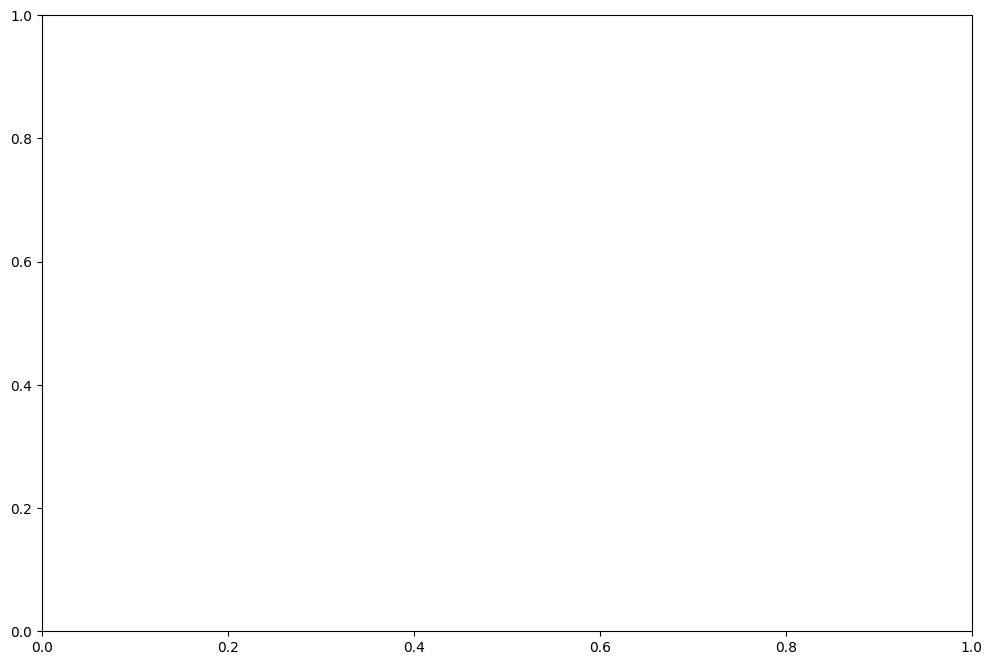

In [402]:

clean.plot.hist(column=["rle_max"], color="Label", figsize=(12, 8))
clean.plot.hist(column=["motif_frac_m6a"], by="Label", figsize=(12, 8))
#pin.plot.hist(column=["msp_start"], by="Label", figsize=(8, 5))
#pin.plot.hist(column=["msp_end"], by="Label", figsize=(8, 5))

In [360]:
def filter_for_msp(g, motif_length=35, dist=100, flank_size=40):
    motif_start = dist
    motif_end = dist + motif_length

    # skip if we are not in an msp region
    msp_starts = g[g.centered_position_type == "msp"].centered_start + 100
    msp_ends = g[g.centered_position_type == "msp"].centered_end + 100
    spanning_msp = (
        (msp_starts < 100) & (msp_ends > 100 + 35)
    )    
    if spanning_msp.sum() > 0:
        return np.ones(g.shape[0], dtype=bool)
    else:
        return np.zeros(g.shape[0], dtype=bool)
has_msp = data.groupby(["chrom", "centering_position", "strand", "query_name"], sort=False).apply(filter_for_msp).to_list()

In [361]:
has_msp_np = np.hstack(has_msp)
msp_data = data[has_msp_np]
data.Label.value_counts(), msp_data.Label.value_counts()

( 1    500000
 -1    500000
 Name: Label, dtype: int64,
  1    387712
 -1    119879
 Name: Label, dtype: int64)

<AxesSubplot: xlabel='centered_start', ylabel='Density'>

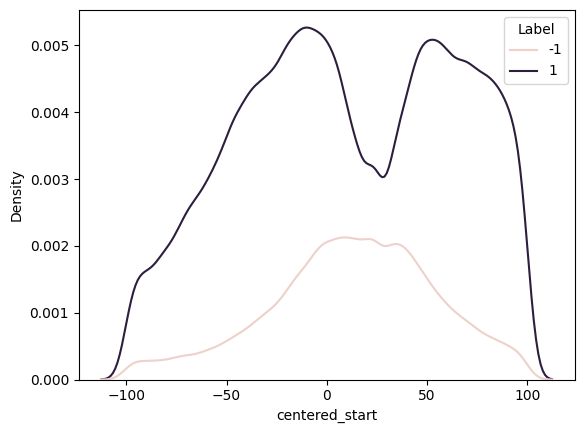

In [362]:
sns.kdeplot(data=msp_data[(msp_data.centered_position_type == "m6a")], x="centered_start", hue="Label")

In [276]:
pin.shape

(8144, 121)

In [388]:
for i in [-1, 1]:
    z  = clean[clean.Label == i].rle_max.value_counts(sort=False).reset_index()
    print(z.sort_values("index").iloc[10:25])

    index  rle_max
10   10.0       57
11   11.0       46
14   12.0       34
8    13.0       26
4    14.0       26
15   15.0       19
16   16.0        4
17   17.0        9
18   18.0        5
19   19.0        1
20   20.0        1
    index  rle_max
9    13.0      314
10   14.0      238
14   15.0      192
12   16.0      150
13   17.0      127
15   18.0      100
18   19.0       59
19   20.0       22
16   22.0       24
17   23.0       12
